In [1]:
# !pip3 install wordcloud

In [2]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

import gensim
from gensim import corpora
from gensim import similarities
from gensim import models
from gensim.models import CoherenceModel

# from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import os
import datetime

import warnings

warnings.filterwarnings("ignore")

from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [3]:
print(datetime.datetime.now())

2024-04-14 14:58:01.527521


/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Import Data

In [4]:
df = pd.read_parquet("processed_data1.parquet")

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
df.head()

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id                                           Headline  \
0   1.0  Grasberg Mine- Grasberg mine workers extend st...   
1   3.0  Shanghai port congestion impacts terminals in ...   
2   5.0  UPDATE - Indonesia: Police confirm two explosi...   
3   6.0  UPDATE - Indonesia: Severe winds damage infras...   
4  14.0  2 miles E of Chesterfield - A tornado has touc...   

                                             Details  Severity  \
0  Media sources indicate that workers at the Gra...  Moderate   
1  The persisting port congestion at Shanghai’s Y...     Minor   
2  According to local police in Jakarta, two expl...   Extreme   
3  Severe winds have downed billboards and trees ...  Moderate   
4  Government sources are reporting a tornado has...     Minor   

                                            Category         Region  \
0                                Mine Workers Strike      Indonesia   
1                                    Port Congestion          China   
2                         Bombing, Police Operations      Indonesia   
3  Roadway Closure / Disruption, Flooding, Severe...      Indonesia   
4                                            Tornado  United States   

        Datetime    Year       lat        lon  ...  if_labeled Month  Week  \
0  28/5/17 17:08  2017.0  -4.05608  137.11302  ...       False   5.0  21.0   
1   27/4/17 9:16  2017.0  29.52000  121.33190  ...       False   4.0  17.0   
2  24/5/17 16:20  2017.0       NaN        NaN  ...        True   5.0  21.0   
3   19/4/17 9:10  2017.0  -6.91264  107.65700  ...        True   4.0  16.0   
4  17/9/18 19:55  2018.0  37.51000  -77.61000  ...        True   9.0  38.0   

                                    Headline_Details  \
0  Grasberg Mine- Grasberg mine workers extend st...   
1  Shanghai port congestion impacts terminals in ...   
2  UPDATE - Indonesia: Police confirm two explosi...   
3  UPDATE - Indonesia: Severe winds damage infras...   
4  2 miles E of Chesterfield - A tornado has touc...   

                                                 url  \
0  https://news.google.com/rss/articles/CBMiZ2h0d...   
1  https://news.google.com/rss/articles/CBMiVWh0d...   
2  https://news.google.com/rss/articles/CBMiZWh0d...   
3  https://news.google.com/rss/articles/CBMiSWh0d...   
4  https://news.google.com/rss/articles/CBMigAFod...   

                                               title  \
0  Freeport Indonesia mine workers extend strike ...   
1  Typhoon Muifa to shut China ports for second t...   
2  Jakarta Police Receive 2 More Reports on Coldp...   
3  Indonesia hit by some of strongest winds recorded   
4  UPDATE: Number of homes without power down to ...   

                                             content  \
0  Trucks are seen on a road in the Grasberg copp...   
1  By Sam Whelan 13/09/2022\n\nAnother typhoon ha...   
2  TEMPO.CO, Jakarta - South Jakarta Metro Police...   
3  A man stands near damaged houses following a t...   
4  More than 90,000 homes and businesses across t...   

                                     cleaned_content  \
0  [truck, be, see, on, road, in, grasberg, coppe...   
1  [by, sam, whelan, typhoon, have, prompt, port,...   
2  [jakarta, south, jakarta, metro, police, recei...   
3  [man, stand, near, damage, house, follow, torn...   
4  [more, than, home, business, across, richmond,...   

                                      binary_content word_count  
0  [adkerson_jakarta_try, agreement_freeport_indo...         53  
1  [additional_ripple_effect, avoid_path_typhoon,...         44  
2  [actress_accord, available_day_concert, click_...         24  
3  [bbc_indonesia, climatologist_government_resea...         28  
4  [advise_seek_alternate, affect_richmond, alter...        134  

[5 rows x 23 columns]

In [6]:
df.shape

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3555, 23)

# Vectorisation

NLP vectorization refers to the process of converting text data into numerical vectors that machine learning algorithms can understand and process. 

Bag-of-Words (BoW) is used here that represents text as a collection of unique words along with their frequencies. Each word is assigned an index, and the vector contains the count of each word present in the document.

In [7]:
df_copy = df.copy()

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# choose only the extreme and severe cases for modelling
cleaned = df_copy[df_copy["Severity"].isin(["Moderate"])]
cleaned.reset_index(drop=True, inplace=True)

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
headline = cleaned.binary_content

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
headline[5]

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['heavy_rainfall', 'accord_state_medium', 'administrative_unit',
       'admiral_armand_balilo', 'alert_china_brace', 'babuyan_island',
       'banca_cause_boat', 'beijing_launch_emergency',
       'binangonan_town_rizal', 'boat_capsize_mbca', 'china_affect',
       'coastal_city', 'coastal_community', 'coastguard_spokesman',
       'control_operation_country', 'dead_country_passenger',
       'early_hour_friday', 'east_manila_pummel', 'eastern_part_island',
       'eastern_taiwan_rainfall', 'eastern_taiwan_shut',
       'fifteen_province', 'flight_cancel', 'flooding_city_luzhou',
       'forecast_storm_cut', 'fujian_china', 'fujian_province',
       'fujian_province_gmt', 'gale_hail', 'heavy_rain',
       'heavy_rainfall_country', 'imminent_landfall_typhoon',
       'issue_railway_service', 'landfall_china', 'landfall_state_news',
       'landslide_typhoon', 'lose_strength_lash', 'main_island_luzon',
       'major_port_city', 'manila_radio_station',
       'national_observatory_

In [11]:
# vectorise the words
doc_dict = gensim.corpora.Dictionary(headline)
docs_vecs = [doc_dict.doc2bow(doc) for doc in headline]

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
print("Number of unique tokens: %d" % len(doc_dict))
print("Number of articles: %d" % len(docs_vecs))

Number of unique tokens: 117199
Number of articles: 1696


/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# Calculate word frequencies
word_frequencies = {doc_dict[word_id]: freq for word_id, freq in doc_dict.cfs.items()}
sorted_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)

pprint(sorted_words[:100])

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('heavy_rain', 125),
 ('supply_chain', 90),
 ('national_weather_service', 69),
 ('strong_wind', 68),
 ('critical_destination_port', 58),
 ('tropical_storm', 53),
 ('industrial_action', 52),
 ('global_supply_chain', 48),
 ('heavy_rainfall', 46),
 ('international_airport', 43),
 ('united_state', 43),
 ('high_yard_density', 42),
 ('social_medium', 40),
 ('global_port_tracker', 39),
 ('global_shipping_disruption', 38),
 ('sign_confidence_consumer', 38),
 ('upgrade_import_forecast', 38),
 ('hong_kong', 37),
 ('new_york_city', 36),
 ('schedule_reliability', 36),
 ('national_hurricane_center', 35),
 ('port_authority', 33),
 ('economic_growth', 33),
 ('mediterranean_demand', 33),
 ('trade_trade_statement', 33),
 ('global_economy', 33),
 ('east_coast', 32),
 ('customer_demand', 32),
 ('trade_statement', 32),
 ('new_york', 31),
 ('severe_weather', 31),
 ('american_market', 31),
 ('relevant_information', 31),
 ('matadi_cape_town', 31),
 ('pacific_trade_statement', 31),
 ('situation_port_face', 3

# LDA Modelling

## Benchmark Model

In [14]:
# Build LDA benchmark model
lda_model = gensim.models.LdaMulticore(
    corpus=docs_vecs,
    id2word=doc_dict,
    num_topics=4,
    random_state=42,
    chunksize=100,
    passes=10,
    per_word_topics=True,
)

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[docs_vecs]

[(0,
  '0.000*"supply_chain" + 0.000*"industrial_action" + 0.000*"heavy_rain" + '
  '0.000*"national_weather_service" + 0.000*"tropical_storm" + '
  '0.000*"power_outage" + 0.000*"customer_demand" + '
  '0.000*"global_supply_chain" + 0.000*"many_country" + '
  '0.000*"critical_destination_port"'),
 (1,
  '0.001*"heavy_rain" + 0.000*"supply_chain" + 0.000*"main_port" + '
  '0.000*"shanghai_port" + 0.000*"port_congestion" + 0.000*"united_state" + '
  '0.000*"landside_operation" + 0.000*"relevant_information" + '
  '0.000*"american_market" + 0.000*"port_authority"'),
 (2,
  '0.000*"global_port_tracker" + 0.000*"global_shipping_disruption" + '
  '0.000*"upgrade_import_forecast" + 0.000*"sign_confidence_consumer" + '
  '0.000*"asian_country" + 0.000*"heavy_rain" + 0.000*"strong_wind" + '
  '0.000*"global_supply_chain" + 0.000*"high_level" + 0.000*"global_economy"'),
 (3,
  '0.001*"heavy_rain" + 0.000*"national_weather_service" + '
  '0.000*"critical_destination_port" + 0.000*"help_business"

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
# Compute Benchmark Coherence Score
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=headline, dictionary=doc_dict, coherence="c_v"
)
coherence_lda = coherence_model_lda.get_coherence()
print("\nCoherence Score LDAModel: ", coherence_lda)

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score LDAModel:  0.37313480890940176


In [17]:
# Compute Benchmark Perplexity
perplex = lda_model.log_perplexity(docs_vecs, total_docs=None)  # For LDAModel
# a measure of how good the model is. lower the better.

print("\nPerplexity for LDAModel: ", perplex)

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity for LDAModel:  -11.567552981485052


In [18]:
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# feed the LDA model into the pyLDAvis instance
pyLDAvis.enable_notebook()
visual = gensimvis.prepare(lda_model, docs_vecs, doc_dict)

# Save the output to the html file
pyLDAvis.save_html(visual, "topic_viz_benchmark_moderate.html")

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
pd.set_option("max_colwidth", 200)
# Get the topics and their top keywords into a dataframe
topics = lda_model.show_topics(num_words=6)

topic_keywords = pd.DataFrame()
for topic_id, topic in topics:
    topic_keywords.at[topic_id, "Topic Keywords"] = topic

topic_keywords["Topic ID"] = topic_keywords.index
# topic_keywords['Topic Name'] = topic_mapping
topic_keywords

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic Keywords  \
0                            0.000*"supply_chain" + 0.000*"industrial_action" + 0.000*"heavy_rain" + 0.000*"national_weather_service" + 0.000*"tropical_storm" + 0.000*"power_outage"   
1                                              0.001*"heavy_rain" + 0.000*"supply_chain" + 0.000*"main_port" + 0.000*"shanghai_port" + 0.000*"port_congestion" + 0.000*"united_state"   
2  0.000*"global_port_tracker" + 0.000*"global_shipping_disruption" + 0.000*"upgrade_import_forecast" + 0.000*"sign_confidence_consumer" + 0.000*"asian_country" + 0.000*"heavy_rain"   
3                 0.001*"heavy_rain" + 0.000*"national_weather_service" + 0.000*"critical_destination_port" + 0.000*"help_business" + 0.000*"website_see_service" + 0.000*"meet_firm"   

   Topic ID  
0         0  
1         1  
2         2  
3         3

In [20]:
# break

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Hyper-Perameter Tuning and Evaluation

Run the cells below only for re-modelling with new datasets, the whole tuning and evaluation process may take hours to run.

In [21]:
# hyper-perameter tuning (alpha and beta)
def compute_coherence_values(corpus, dictionary, k, a, b):

    lda_model = gensim.models.LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k,
        random_state=42,
        chunksize=100,
        passes=10,
        alpha=a,
        eta=b,
    )

    coherence_model_lda = CoherenceModel(
        model=lda_model, texts=headline, dictionary=doc_dict, coherence="c_v"
    )
    coherence = coherence_model_lda.get_coherence()
    perplex = lda_model.log_perplexity(docs_vecs, total_docs=None)

    return coherence, perplex

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# setup
import numpy as np

from gensim.models import CoherenceModel

model_list = []
coherence_values = []
perplexity_values = []
model_topics = []
alpha_result = []
beta_result = []

# topic ranges
num_topics = range(4, 13)

# Alpha parameter
alpha = list(np.arange(0.31, 1, 0.3))
alpha.append("symmetric")
alpha.append("asymmetric")

# Beta parameter
beta = list(np.arange(0.31, 1, 0.3))
beta.append("symmetric")

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Rational behind the alpha and eta: https://stats.stackexchange.com/questions/37405/natural-interpretation-for-lda-hyperparameters

In [23]:
print("Topic range: ", num_topics)
print("Alpha: ", alpha)
print("Beta: ", beta)

Topic range:  range(4, 13)
Alpha:  [0.31, 0.61, 0.9099999999999999, 'symmetric', 'asymmetric']
Beta:  [0.31, 0.61, 0.9099999999999999, 'symmetric']


/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
import datetime
import numpy as np
from gensim.models import CoherenceModel

print(datetime.datetime.now())

for a in alpha:
    for b in beta:
        for num in num_topics:
            cv, pv = compute_coherence_values(
                corpus=docs_vecs, dictionary=doc_dict, k=num, a=a, b=b
            )

            model_topics.append(num)
            coherence_values.append(cv)
            perplexity_values.append(pv)
            alpha_result.append(a)
            beta_result.append(b)
            print(
                "#Topics: "
                + str(num)
                + ", CV Score: "
                + str(coherence_values[-1])
                + ", PV Score: "
                + str(perplexity_values[-1])
                + ", Alpha: "
                + str(alpha_result[-1])
                + ", Beta: "
                + str(beta_result[-1])
            )

print(datetime.datetime.now())

2024-04-14 14:58:21.806761


/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Topics: 4, CV Score: 0.4639120100070641, PV Score: -11.464789668175275, Alpha: 0.31, Beta: 0.31
#Topics: 5, CV Score: 0.5201240130087459, PV Score: -11.419304959935175, Alpha: 0.31, Beta: 0.31
#Topics: 6, CV Score: 0.5306883696213397, PV Score: -11.389754078309831, Alpha: 0.31, Beta: 0.31
#Topics: 7, CV Score: 0.4501096856569587, PV Score: -11.359337921238922, Alpha: 0.31, Beta: 0.31
#Topics: 8, CV Score: 0.5544991941875896, PV Score: -11.348405818868896, Alpha: 0.31, Beta: 0.31
#Topics: 9, CV Score: 0.4574277500533525, PV Score: -11.32308976427175, Alpha: 0.31, Beta: 0.31
#Topics: 10, CV Score: 0.5857931657753643, PV Score: -11.324607585088907, Alpha: 0.31, Beta: 0.31
#Topics: 11, CV Score: 0.556279187731952, PV Score: -11.329564884447464, Alpha: 0.31, Beta: 0.31
#Topics: 12, CV Score: 0.5255844718897261, PV Score: -11.322565125444651, Alpha: 0.31, Beta: 0.31
#Topics: 4, CV Score: 0.5198268311028859, PV Score: -11.444283658927644, Alpha: 0.31, Beta: 0.61
#Topics: 5, CV Score: 0.52195

The table below reveals the top 20 fine tuned models with best combinations of coherence score and perplexity score. It was sorted by the coherence score in descending order as a higher coherence score indicates a better model, and sorted the perplexity score in ascending order as a lower perplexity score indicates a better model. While coherence score evaluates the quality of the topics, the perplexity score evaluates the overall performance of the model in predicting new documents. Usually, the coherence score is a better metric to use if the goal is to obtain topics that are semantically coherent and interpretable. Perplexity score, on the other hand, is a better metric to use if the goal is to build a model that generalises well to new data, in other words, how confident the model is in predicting the new data (Sánchez-Aguayo, et al., 2022). Ultimately, we aim to get a balance between the perplexity value and coherence score when determining our final model.

In [25]:
# Find the top 20 combinations based on Coherence Score and Perplexity Score
result = pd.DataFrame(
    {
        "Topics": model_topics,
        "Coherence Score": coherence_values,
        "Perplexity Score": perplexity_values,
        "Alpha": alpha_result,
        "Beta": beta_result,
    }
)
result.sort_values(
    by=["Coherence Score", "Perplexity Score"], ascending=[False, True]
).head(20)

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topics  Coherence Score  Perplexity Score      Alpha       Beta
53       12         0.606705        -11.517395       0.61       0.61
140       9         0.596915        -11.387579  symmetric  symmetric
142      11         0.591756        -11.364024  symmetric  symmetric
91        5         0.589326        -11.492436       0.91       0.91
43       11         0.589220        -11.392128       0.61       0.31
92        6         0.589178        -11.498234       0.91       0.91
6        10         0.585793        -11.324608       0.31       0.31
122       9         0.585486        -11.352325  symmetric       0.61
70       11         0.580385        -11.484144       0.61  symmetric
124      11         0.579739        -11.338405  symmetric       0.61
24       10         0.576809        -11.443981       0.31       0.91
133      11         0.573105        -11.388777  symmetric       0.91
61       11         0.569172        -11.504310       0.61       0.91
89       12         0.567969        -11.508772       0.91       0.61
106      11         0.567736        -11.576884       0.91  symmetric
14        9         0.566258        -11.392017       0.31       0.61
52       11         0.566011        -11.448195       0.61       0.61
107      12         0.564555        -11.722290       0.91  symmetric
79       11         0.563732        -11.434902       0.91       0.31
115      11         0.563260        -11.277389  symmetric       0.31

In [26]:
result.to_csv("lda_fine_tuning_result.csv")

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Alpha
0.31                  Axes(0.125,0.125;0.775x0.755)
0.61                  Axes(0.125,0.125;0.775x0.755)
0.9099999999999999    Axes(0.125,0.125;0.775x0.755)
asymmetric            Axes(0.125,0.125;0.775x0.755)
symmetric             Axes(0.125,0.125;0.775x0.755)
dtype: object

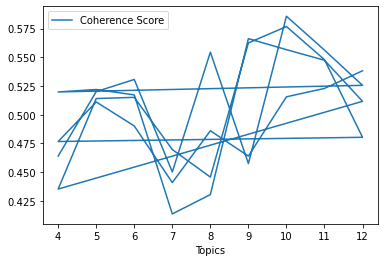

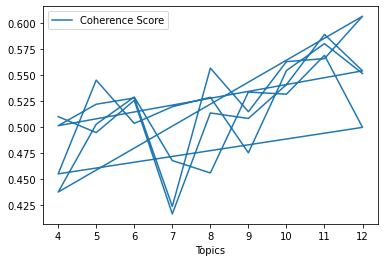

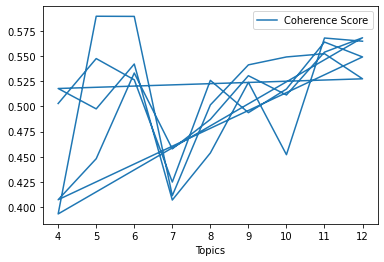

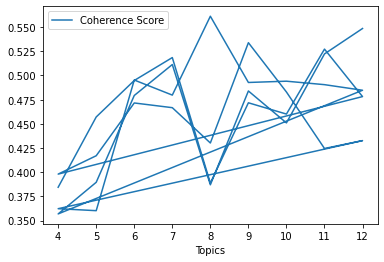

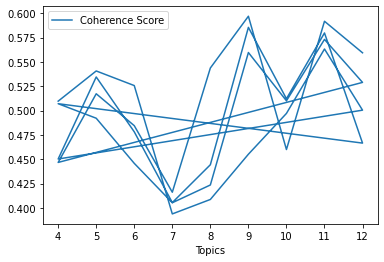

In [27]:
# Show graph Topics vs Coherence Score
result.groupby("Alpha").plot(x="Topics", y="Coherence Score", legend=True)

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


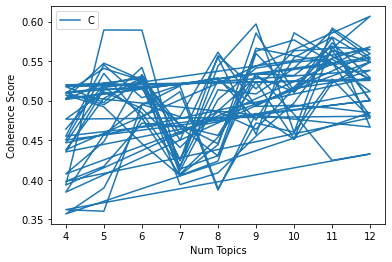

In [28]:
# Show graph Topics vs Perplexity Score

plt.plot(model_topics, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(("Coherence Score"), loc="best")
plt.show()

/Users/wyf/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


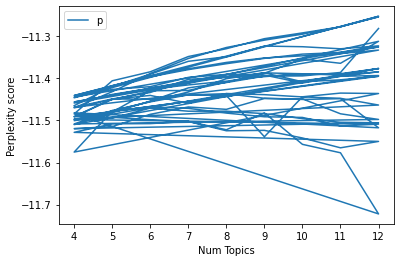

In [29]:
# Show graph Topics vs Perplexity Score

plt.plot(model_topics, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc="best")
plt.show()

## Final Model

In [68]:
# realised that there may be some overlaps for more than 5 topics, but below 5 topics results in low differentiation and high ambiguity among the topics.
# LDA is not suitable for this dataset
k = 9
a = "symmetric"
# a = 0.31
# b = 0.31
b = "symmetric"


final_model = gensim.models.LdaMulticore(
    corpus=docs_vecs,
    id2word=doc_dict,
    num_topics=k,
    random_state=42,
    chunksize=100,
    passes=10,
    alpha=a,
    eta=b,
)

In [54]:
compute_coherence_values(corpus=docs_vecs, dictionary=doc_dict, k=k, a=a, b=b)

(0.5969151993457286, -11.387578913849133)

In [55]:
# Set up the environment to display the graphical outputs
# feed the LDA model into the pyLDAvis instance
pyLDAvis.enable_notebook()
visual = gensimvis.prepare(final_model, docs_vecs, doc_dict)

# Save the output to the html file
pyLDAvis.save_html(visual, "topic_viz12_mod_training.html")

In [56]:
final_model.print_topics(num_words=30)

[(0,
  '0.001*"supply_chain" + 0.000*"critical_destination_port" + 0.000*"pacific_trade_statement" + 0.000*"additional_capacity_cater" + 0.000*"peak_season" + 0.000*"terminal_productivity_situation" + 0.000*"full_network" + 0.000*"major_disruption_trade" + 0.000*"international_airport_company" + 0.000*"shanghai_shekou" + 0.000*"new_cargo_area" + 0.000*"narita_airport_concept" + 0.000*"composite_pmi" + 0.000*"boa_day" + 0.000*"container_load_lcl" + 0.000*"inflation_rate_peak" + 0.000*"squeeze_consumer_purchase" + 0.000*"consumer_confidence" + 0.000*"heavy_rain" + 0.000*"second_quarter" + 0.000*"national_weather_service" + 0.000*"global_supply_chain" + 0.000*"global_economy" + 0.000*"many_country" + 0.000*"good_trade" + 0.000*"geopolitical_risk" + 0.000*"express_concern" + 0.000*"freight_service" + 0.000*"public_holiday" + 0.000*"small_medium"'),
 (1,
  '0.000*"day_day_day" + 0.000*"heavy_rain" + 0.000*"american_port" + 0.000*"supply_chain" + 0.000*"american_market" + 0.000*"state_port" 

# Save the final model 

In [57]:
# Save a model to disk, or reload a pre-trained model
# naming convention: final_model_topic_alpha_eta
final_model.save("final_model_9_sym_sym")

# Find dominant topic(s) for each news article

Attach the dominant topics back to the news dataset for classifying purpose.

Made use of gensim lda's own function: https://radimrehurek.com/gensim/models/ldamodel.html

In [58]:
import warnings

warnings.filterwarnings("ignore")


def format_topics_sentences(ldamodel, corpus, data):
    # Preallocate memory for the DataFrame
    num_docs = len(corpus)
    sent_topics = {
        "Dominant_Topic": [0] * num_docs,
        "Perc_Contribution": [0.0] * num_docs,
        "Topic_Distribution": [()] * num_docs,
    }

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        if row:
            # Get the Dominant topic, Perc Contribution and Keywords for each document
            dominant_topic, perc_contribution = row[0]
            topic_distribution = row
            sent_topics["Dominant_Topic"][i] = int(dominant_topic)
            sent_topics["Perc_Contribution"][i] = round(perc_contribution, 4)
            sent_topics["Topic_Distribution"][i] = topic_distribution

    # Create the DataFrame
    sent_topics_df = pd.DataFrame(sent_topics)
    sent_topics_df["Text"] = data

    return sent_topics_df

In [59]:
df_topic_sents_keywords = format_topics_sentences(
    ldamodel=final_model, corpus=docs_vecs, data=cleaned.Headline_Details
)

In [60]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
    "Document_No",
    "Dominant_Topic",
    "Topic_Perc_Contrib",
    "Topic_Distribution",
    "Text",
]

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib Topic_Distribution  \
0            0               6              0.9834   [(6, 0.9834445)]   
1            1               6              0.9692   [(6, 0.9691763)]   
2            2               7              0.9765   [(7, 0.9764757)]   
3            3               1              0.9982  [(1, 0.99823475)]   
4            4               0              0.9884  [(0, 0.98838603)]   
5            5               4              0.9882  [(4, 0.98823905)]   
6            6               6              0.9944  [(6, 0.99439585)]   
7            7               0              0.9787  [(0, 0.97869843)]   
8            8               3              0.9867  [(3, 0.98665065)]   
9            9               5              0.9897   [(5, 0.9897034)]   

                                                                                                                                                                                                      Text  
0  Grasberg Mine- Grasberg mine workers extend strike for a fourth month. Media sources indicate that workers at the Grasberg mine will extend their strike for a fourth month as disputes regarding la...  
1  UPDATE - Indonesia: Severe winds damage infrastructure in Bandung, West Java Severe winds have downed billboards and trees in Bandung on Wednesday afternoon. According to local media sources, the ...  
2  270 kilograms of heroin discovered in container at Port of Genoa Local media sources indicated on November 8 that 270 kilograms of heroin arrived from Iran were discovered in containers at the Por...  
3  6 miles S of San Antonio - A magnitude 5.2 earthquake was detected in the region. Incident closed. The European-Mediterranean Seismological Centre (EMSC) reported a magnitude 5.2 earthquake that s...  
4  6 suspects steal truck and take driver hostage in Santos Local media sources indicate on October 18 that 6 suspects hijacked a truck in Santos on the evening of October 15, releasing the driver in...  
5  7 ships grounded in Taiwan due to Tropical Depression Media sources reported that 6 container ships and a tanker were grounded due to the passing of a Tropical Depression near Taiwan on August 24....  
6  Adelaide   Utility workers have restored power to all customers. Incident closed. SA Power Networks has restored power to all customers after a wind storm caused thousands to be without power acro...  
7  Airframe Dr & Boeing Blvd - Boeing operations will resume beginning on Sunday night. The Boeing Company operations will resume in North Charleston beginning Sunday night after shutting down due to...  
8  All terminals closed at Port of Le Havre Industry sources indicate on December 28 that all terminals are closed at the Port of Le Havre. The closures are believed to be linked to Act VI of the Yel...  
9  American Airlines Flight Attendants to Picket at 15 Airports Across the US on Sunday, November 18 On Sunday, November 18, American Airlines flight attendants represented by the Association of Prof...

# Result Analysis

In [61]:
df_dominant_topic["Dominant_Topic"].value_counts()

0    251
3    217
8    207
5    206
2    173
6    164
4    163
7    159
1    156
Name: Dominant_Topic, dtype: int64

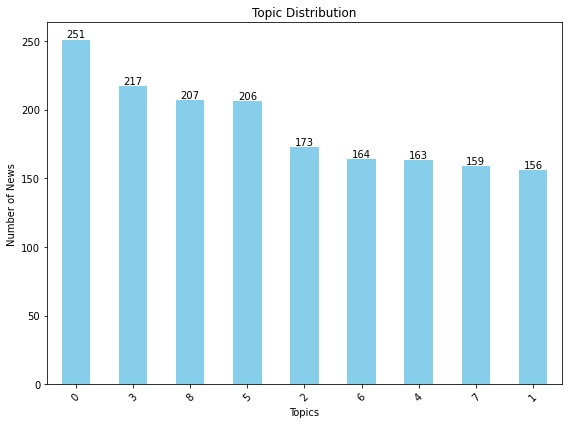

In [62]:
import matplotlib.pyplot as plt

# Get value counts of each topic
topic_counts = df_dominant_topic["Dominant_Topic"].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
topic_counts.plot(kind="bar", color="skyblue")

# Add labels to the bars
for i, count in enumerate(topic_counts):
    plt.text(i, count, str(count), ha="center", va="bottom")

# Add labels and title
plt.xlabel("Topics")
plt.ylabel("Number of News")
plt.title("Topic Distribution")

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [64]:
df_dominant_topic.shape

(1696, 5)

In [ ]:
# Sample 100 rows, can change the random_state for different samples
sampled_data = df_dominant_topic.sample(n=100, random_state=42)
sampled_df = pd.DataFrame(sampled_data).reset_index()
sampled_df.to_csv("sample_moderate.csv")